HW1 - Connor Jacobs
Overview
Using the data linked on canvas (hw1.csv) build the models as described below that
use all the X variables (`X1`, `X2`... `X8`) to predict Group. Make sure that data is
z scored appropriately. Due to the number of models you're fitting with
GridSearch, this make take a while to run

Imports

In [60]:
import warnings
warnings.filterwarnings('ignore')

# data and plotting
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures #Z-score variables
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split, GridSearchCV
# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay, roc_auc_score, recall_score, precision_score, ConfusionMatrixDisplay


# models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

Dataframe

In [61]:
d = pd.read_csv("hw1.csv")
d

,X1,X2,X3,X4,X5,X6,X7,X8,Group
0,-0.604285,-0.610629,0.026014,0.019710,0.406532,0.678796,0.524360,0.404739,B
1,-0.111772,-1.125178,0.744157,0.078315,0.088176,0.891009,0.018460,0.536511,B
2,-0.916802,1.965494,0.150022,0.388770,0.179276,0.064449,0.159279,0.951204,B
3,-0.280479,0.920669,0.208949,0.940153,0.854437,0.688172,0.365126,0.985259,A
4,1.856025,1.043214,0.167088,0.207002,0.979049,0.641019,0.628764,0.045912,B
...,...,...,...,...,...,...,...,...,...
995,-1.491561,-0.029565,0.157170,0.757189,0.658023,0.736780,0.829090,0.731367,A
996,1.982941,2.004336,0.980436,0.626487,0.986931,0.191123,0.584592,0.421419,B
997,1.909870,1.798968,0.980869,0.795731,0.818800,0.120555,0.289683,0.296811,B
998,1.534406,0.646135,0.242840,0.923465,0.073217,0.189167,0.481032,0.143368,A


Drop null values

In [62]:
missing_values = d.isnull().sum()
d.dropna(inplace = True)
d.reset_index(inplace = True)

In [63]:
d.head()

,index,X1,X2,X3,X4,X5,X6,X7,X8,Group
0,0,-0.604285,-0.610629,0.026014,0.019710,0.406532,0.678796,0.524360,0.404739,B
1,1,-0.111772,-1.125178,0.744157,0.078315,0.088176,0.891009,0.018460,0.536511,B
2,2,-0.916802,1.965494,0.150022,0.388770,0.179276,0.064449,0.159279,0.951204,B
3,3,-0.280479,0.920669,0.208949,0.940153,0.854437,0.688172,0.365126,0.985259,A
4,4,1.856025,1.043214,0.167088,0.207002,0.979049,0.641019,0.628764,0.045912,B


Step 1

In [64]:
contin = ["index", "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8"]

# Define predictors and ensure they exist in the DataFrame
predictors = [c for c in d.columns if c != "Group"]

# Check for columns that might not exist in the DataFrame
missing_cols = [col for col in contin if col not in d.columns]
if missing_cols:
    print(f"Missing columns in DataFrame: {missing_cols}")
    contin = [col for col in contin if col in d.columns]

# Define X and y
X = d[predictors]
y = d["Group"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Step 2

Best parameters: {'svm__C': 50, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best cross-validation accuracy: 0.76875
Training accuracy: 0.79625
Testing accuracy: 0.725
Training AUC: 0.8741397747177412
Testing AUC: 0.7831622383252819


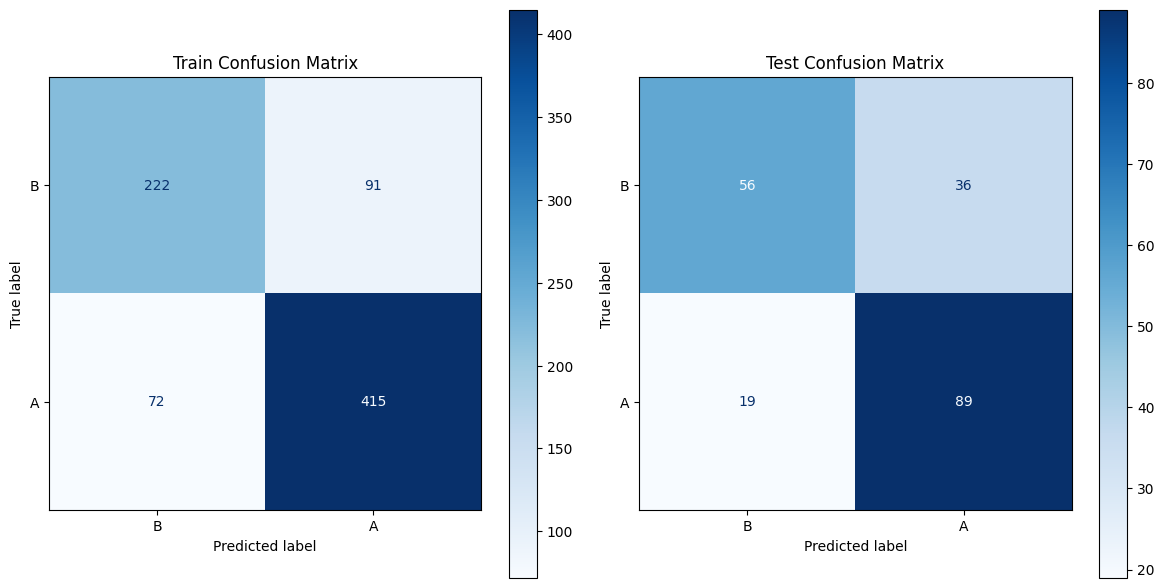

In [54]:
# Define the preprocessing pipeline
preprocess = make_column_transformer(
    (StandardScaler(), contin),  # Ensure these columns exist in X
    remainder="passthrough"
)

# Define the SVM pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('svm', SVC(probability=True))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': [0.001, 0.01, 1, 5, 25, 50],
    'svm__gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5]
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score from GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict on training and testing sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate and print train and test accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)

# Calculate and print ROC AUC scores
train_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1], multi_class='ovo')
test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1], multi_class='ovo')
print("Training AUC:", train_auc)
print("Testing AUC:", test_auc)

# Correct usage of subplots for confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_train, y_train, display_labels=y.unique(), cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Train Confusion Matrix')

# Test confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=y.unique(), cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

Step 3

Train Accuracy: 0.7738
Test Accuracy: 0.7100
Train ROC AUC: 0.8591
Test ROC AUC: 0.7821


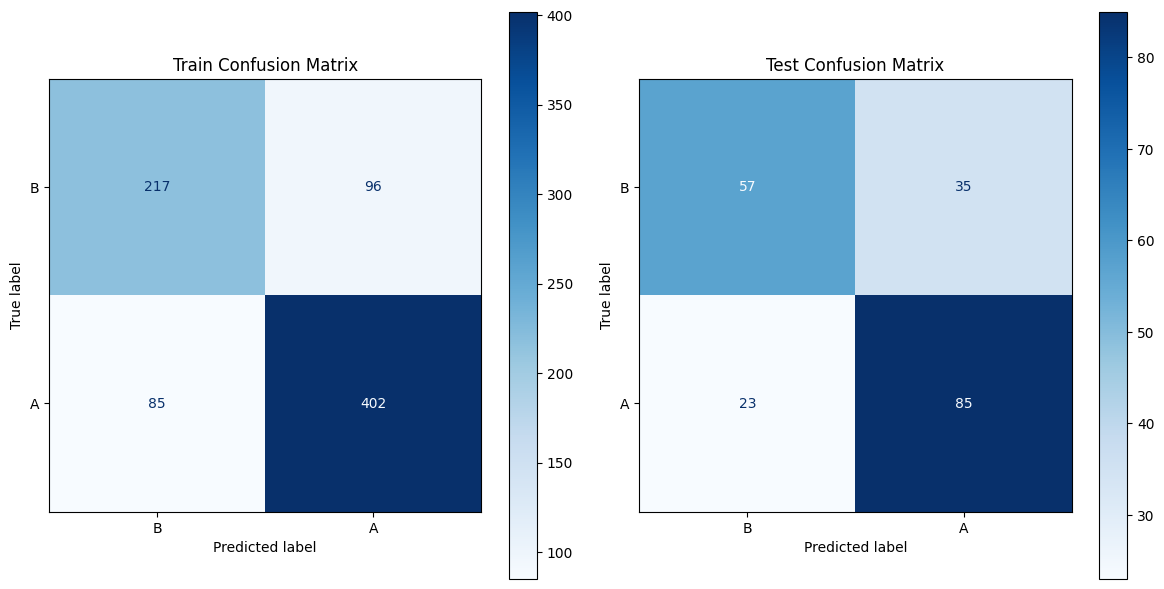

In [58]:
lr = LogisticRegression()

# Create a pipeline with preprocessing and logistic regression
pipe = Pipeline([
    ("pre", preprocess),
    ("logreg", lr)
])

# Fit the model
pipe.fit(X_train, y_train)

# Predict on train and test sets
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Print accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print ROC AUC scores (assuming binary classification)
train_roc_auc = roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

# Plot train and test confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=y.unique(), cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Train Confusion Matrix')

# Test confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=y.unique(), cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

Step 4

Best n_neighbors: 1
Train Accuracy: 1.0000
Test Accuracy: 0.5250
Train ROC AUC: 1.0000
Test ROC AUC: 0.5175


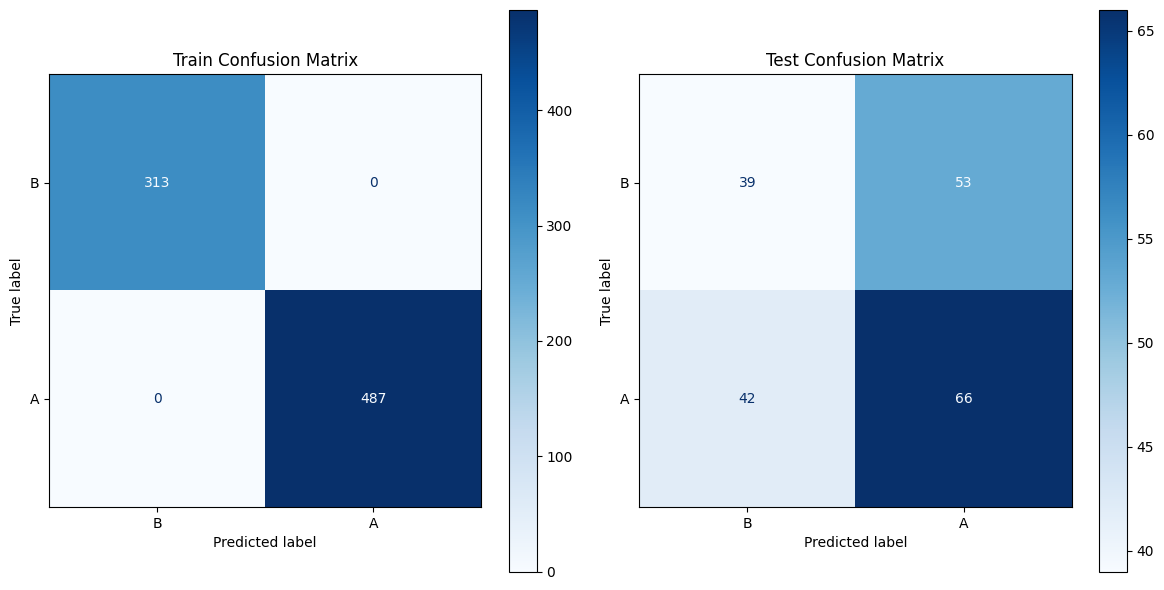

In [65]:
knn = KNeighborsClassifier()

# Create a pipeline with preprocessing and k-NN
pipe = Pipeline([
    ("preprocess", preprocess),
    ("knn", knn)
])

# Define a parameter grid for n_neighbors
param_grid = {'knn__n_neighbors': list(range(1, 21))}

# Use GridSearchCV to find the best n_neighbors
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best number of neighbors
best_n_neighbors = grid_search.best_params_['knn__n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

# Train the k-NN model using the optimal number of neighbors
best_knn = grid_search.best_estimator_

# Predict on the training and testing sets
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC scores for training and testing sets (assuming binary classification)
train_roc_auc = roc_auc_score(y_train, best_knn.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

# Plot train and test confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=y.unique(), cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Train Confusion Matrix')

# Test confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=y.unique(), cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()